# Yahoo Topic Classification

## Setting up Libraries and Environments

In [71]:
# Basic
import pandas as pd
import numpy as np
import findspark
import pyspark
from pyspark import SparkFiles

# Data Manipulation
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.window import Window

# ML
from pyspark.ml.feature import *
from pyspark.ml.linalg import Vector
from pyspark.ml import Pipeline
from pyspark.ml.classification import OneVsRest, LinearSVC, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [72]:
findspark.init()

spark = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()

## Data Import

In [73]:
schema_list = [
    StructField('Label', StringType(), False), 
    StructField('Title', StringType(), True), 
    StructField('Content', StringType(), True),
    StructField('Answer', StringType(), True),
    StructField('Set', StringType(), True)
]
schema_df = StructType(fields=schema_list)

In [74]:
# Import Data from reduced folders
df = spark.read.csv("../data/reduced", schema=schema_df)

## Data Preview
This includes some basic view of the data before processing

In [75]:
df.show(5)

+-----+--------------------+--------------------+--------------------+-----+
|Label|               Title|             Content|              Answer|  Set|
+-----+--------------------+--------------------+--------------------+-----+
|    9|I've tried talkin...|                null|~I was going to s...|Train|
|    2|Find the coordina...|Find the coordina...|"Let P be (a,b). ...|Train|
|    6|       Who will win?|Who's gonna win t...|ND go irish. USC ...|Train|
|   10|    Where do I vote?|                null|If you don't know...|Train|
|    2| help for the s.a.t?|can anyone give m...|Try some of these...|Train|
+-----+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



In [76]:
# checking example for the writeup
df.filter(col('Title').contains('Is the universe flat')).show(truncate=50)

+-----+---------------------+-------+--------------------------------------------------+----+
|Label|                Title|Content|                                            Answer| Set|
+-----+---------------------+-------+--------------------------------------------------+----+
|    2|Is the universe flat?|   null|"Yes, the Universe is flat. It's a VERY difficu...|Test|
+-----+---------------------+-------+--------------------------------------------------+----+



In [77]:
df.describe().show()

+-------+------------------+--------------------+--------------------------------+----------------------+------+
|summary|             Label|               Title|                         Content|                Answer|   Set|
+-------+------------------+--------------------+--------------------------------+----------------------+------+
|  count|            365124|              365124|                          201247|                358339|365124|
|   mean| 5.493070847164251|                null|                        Infinity|              Infinity|  null|
| stddev|2.8693308861059896|                null|                             NaN|                   NaN|  null|
|    min|                 1|! Does anyone els...|                               !|  ! ""Please excuse...|  Test|
|    max|                 9|﻿Speculate about ...|나보기가역겨워. 가실 때에는. ...|혼돈\nhttp://dictio...| Train|
+-------+------------------+--------------------+--------------------------------+----------------------+-----

## Data Processing

### Steps to Take
- Merge Test and Train
- Rename columns
- Change data types
- Tokenization
- Stop Word Removal
- NGram

#### Column Concatenation

In [78]:
df = df.fillna('')

In [79]:
df = df.withColumn('Document', concat(df['Title'], df['Content'], df['Answer'])).select(['Document', 'Set', 'Label'])
df.show(5)

+--------------------+-----+-----+
|            Document|  Set|Label|
+--------------------+-----+-----+
|I've tried talkin...|Train|    9|
|Find the coordina...|Train|    2|
|Who will win?Who'...|Train|    6|
|Where do I vote?I...|Train|   10|
|help for the s.a....|Train|    2|
+--------------------+-----+-----+
only showing top 5 rows



In [80]:
df.filter(length('Document') == 10).show(truncate=50)

+--------+---+-----+
|Document|Set|Label|
+--------+---+-----+
+--------+---+-----+



In [81]:
df.select("Document").where(length("Document") == 11).show(truncate=False)

+-----------+
|Document   |
+-----------+
|Wats a RM ?|
|h.i.p.p.a.?|
|"""Don'tAsk|
|r u a girl?|
|preaching'?|
+-----------+



In [82]:
before = df.count()
before_train = df.filter('Set == "Train"').count()
before_test = df.filter('Set == "Test"').count()
df = df.filter('Document is NOT NULL').withColumn('Length', length(df['Document']))
after = df.count()
after_train = df.filter('Set == "Train"').count()
after_test = df.filter('Set == "Test"').count()

In [83]:
print(f'''There were {before_train} training samples and {before_test} test samples''')
print(f'{before - after} rows were dropped, {before_train - after_train} training samples and {before_test - after_test} test samples.')
print(f'''There are now {df.filter('Set == "Train"').count()} training samples and {df.filter('Set == "Test"').count()} test samples''')

There were 350042 training samples and 15082 test samples
0 rows were dropped, 0 training samples and 0 test samples.


There are now 350042 training samples and 15082 test samples


### Full Processing Pipeline

#### Full Experiment

In [84]:
schema_results = StructType([ \
    StructField("FeatureLength",IntegerType(),True), \
    StructField("Accuracy", StringType(), True)\
  ])

df_results_full = spark.createDataFrame(data=[(None,None)], schema=schema_results)

reg_tokenizer = RegexTokenizer(inputCol='Document', outputCol='Tokens', pattern='\\W')
stop_word_remover = StopWordsRemover(inputCol='Tokens', outputCol='StopTokens')
string_indexer = StringIndexer(inputCol='Label', outputCol='LabelString')
rf = RandomForestClassifier(featuresCol='TF-IDF', labelCol='LabelString')
evaluator = MulticlassClassificationEvaluator(labelCol='LabelString')

for numFeatures in [6000]:
    tf = HashingTF(inputCol='StopTokens', outputCol='CountVec', numFeatures=numFeatures)
    idf = IDF(inputCol='CountVec', outputCol='TF-IDF')

    # Putting pipeline together
    pipeline = Pipeline(stages=[
        reg_tokenizer,
        stop_word_remover,
        tf,
        idf,
        string_indexer,
    ])

    # Training and fitting
    pipeline = pipeline.fit(df)
    df_processed = pipeline.transform(df)

    df_train = df_processed.filter('Set == "Train"').select('Document', 'TF-IDF', 'LabelString')
    df_test = df_processed.filter('Set == "Test"').select('Document', 'TF-IDF', 'LabelString')

    rfModel = rf.fit(df_train)
    predictions = rfModel.transform(df_test)

    accuracy = evaluator.evaluate(predictions)

    vals = [(numFeatures, accuracy)]
    new_row = spark.createDataFrame(data=vals, schema=schema_results)
    df_results_full = df_results_full.union(new_row)


22/12/17 20:26:13 WARN MemoryStore: Not enough space to cache rdd_820_1 in memory! (computed 535.6 MiB so far)
22/12/17 20:26:13 WARN BlockManager: Persisting block rdd_820_1 to disk instead.
22/12/17 20:26:14 WARN MemoryStore: Not enough space to cache rdd_820_7 in memory! (computed 535.6 MiB so far)
22/12/17 20:26:14 WARN BlockManager: Persisting block rdd_820_7 to disk instead.
22/12/17 20:26:14 WARN MemoryStore: Not enough space to cache rdd_820_3 in memory! (computed 535.6 MiB so far)
22/12/17 20:26:14 WARN BlockManager: Persisting block rdd_820_3 to disk instead.
22/12/17 20:26:14 WARN MemoryStore: Not enough space to cache rdd_820_4 in memory! (computed 535.6 MiB so far)
22/12/17 20:26:14 WARN BlockManager: Persisting block rdd_820_4 to disk instead.
22/12/17 20:26:14 WARN MemoryStore: Not enough space to cache rdd_820_0 in memory! (computed 535.6 MiB so far)
22/12/17 20:26:14 WARN BlockManager: Persisting block rdd_820_0 to disk instead.
22/12/17 20:26:29 WARN MemoryStore: Not 

In [85]:
df_results_full.show()

+-------------+-------------------+
|FeatureLength|           Accuracy|
+-------------+-------------------+
|         null|               null|
|         6000|0.38779613624007353|
+-------------+-------------------+



In [14]:
df_results_full.write.csv('../results/random_forest')

In [15]:
tsne_df = df_processed.select('TF-IDF', 'LabelString').toPandas()

### Evaluating results

We saw that increasing the size of tf-idf vector continues to increase the accuracy of the model up to the upper limit we set, but the results with random forest are less than that of the linear SVM at this classification task.

In [54]:
# Plot results in lineplot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
# Add Diarmuid's results for visualisation
data = [
        (1000, 0.509)
        ,(2000, 0.572)
        ,(3000, 0.601)
        ,(4000, 0.617)
        ,(5000, 0.627)
        ,(6000, 0.634)

  ]

schema = StructType([ \
    StructField("FeatureLength",IntegerType(),True), \
    StructField("Accuracy", StringType(), True)\
  ])
 
df_svm_results = spark.createDataFrame(data=data, schema=schema).toPandas()
df_svm_results['Accuracy'] = df_svm_results['Accuracy'].astype(float)
df_svm_results['FeatureLength'] = df_svm_results['FeatureLength'].astype(float)
df_svm_results['model'] = 'svm'


In [50]:
df_rf = df_results_full.toPandas().iloc[1:, :]
df_rf['Accuracy'] = df_rf['Accuracy'].astype(float)
df_svm_results['FeatureLength'] = df_svm_results['FeatureLength'].astype(int)

df_rf['model'] = 'rf'

In [51]:
df_results = pd.concat([df_rf, df_svm_results])

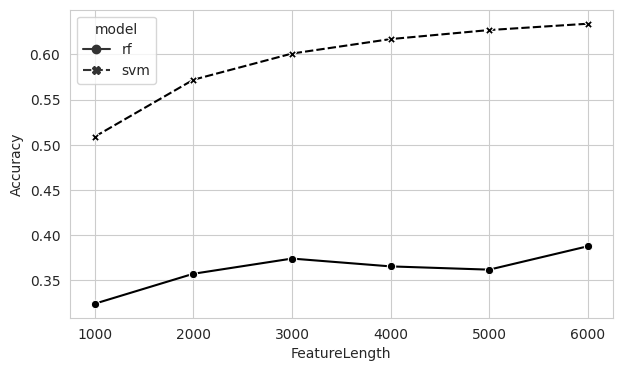

In [57]:
sns.set_style('whitegrid')

plt.figure(figsize=(7, 4))
sns.lineplot(x='FeatureLength', y='Accuracy', data=df_results, markers=True, marker="o", color='black', style='model')
plt.show()

In [31]:
predictions.show(5)

+--------------------+--------------------+-----------+--------------------+--------------------+----------+
|            Document|              TF-IDF|LabelString|       rawPrediction|         probability|prediction|
+--------------------+--------------------+-----------+--------------------+--------------------+----------+
|do you think i sh...|(6000,[248,270,33...|        2.0|[2.42061859264531...|[0.12103092963226...|       7.0|
|any ideas on quit...|(6000,[335,540,56...|        2.0|[1.97808017203919...|[0.09890400860195...|       2.0|
|can you guess thi...|(6000,[2281,2535,...|        3.0|[2.04952832155116...|[0.10247641607755...|       1.0|
|Do u believe in g...|(6000,[234,533,10...|        0.0|[1.95395420711933...|[0.09769771035596...|       4.0|
|what hapeend to t...|(6000,[432,2278,2...|        8.0|[2.05819707930117...|[0.10290985396505...|       6.0|
+--------------------+--------------------+-----------+--------------------+--------------------+----------+
only showing top 5 

In [58]:
rf.getNumTrees()

20

In [32]:
incorrect_pred = predictions.filter(col('LabelString') != col('prediction')).select('Document', 'LabelString', 'prediction').toPandas()
correct_pred = predictions.filter(col('LabelString') == col('prediction')).select('Document', 'LabelString', 'prediction').toPandas()


In [33]:
incorrect_pred.sample(5, random_state=1)

,Document,LabelString,prediction
1917,"Anyone know about boxing?K, so I'm getting rea...",8.0,7.0
685,How can I get my programs (like Photoshop or I...,5.0,2.0
1685,What are some political issues that affect you...,9.0,1.0
288,Do women think much about sleeping with there ...,7.0,1.0
2403,Why is the Wii called Wii? Its such an ugly na...,3.0,1.0


In [34]:
correct_pred.sample(5, random_state=1)

,Document,LabelString,prediction
1300,"""who and what is this song called? """"I will n...",3.0,3.0
2856,could anyone tell me what a complete volume of...,1.0,1.0
554,Has anyone on here had Pectus Excavatum? Or kn...,2.0,2.0
3954,do males or female have a better sense of smel...,6.0,6.0
5519,Who's gonna win this Sat Night UFC Matt Serra ...,8.0,8.0
